# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
lat_size = 100
sweeps = 50
Temps = [1.0, 1.5, 2.0]

# Step 1 - Generating Ising Model Samples

In [3]:
from gibbs_sampling_funcs import gibbs_sampler

In [4]:
x = []
for Temp in Temps:
    print("Temp = " + str(Temp))
    print("Sampling:")
    s = time.time()
    x.append(gibbs_sampler(Temp, sweeps, lat_size))
    e = time.time()
    print("Done (" + str(round(e - s, 2)) + " secs).")
    print("---------------")

Temp = 1.0
Sampling:
Done (25.05 secs).
---------------
Temp = 1.5
Sampling:
Done (23.77 secs).
---------------
Temp = 2.0
Sampling:
Done (23.71 secs).
---------------


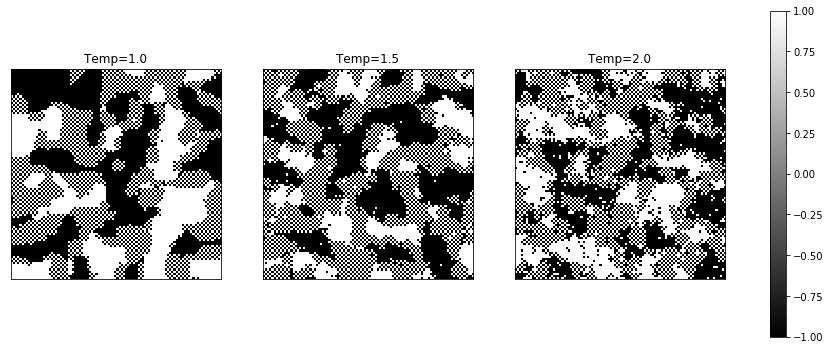

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(16, 6))

for i, Temp in enumerate(Temps):
    t = ax[i].imshow(x[i], interpolation="None", vmin=-1, vmax=1, cmap="gray")
    ax[i].set_xticks([]), ax[i].set_yticks([])
    ax[i].set_title("Temp=" + str(Temp))

fig.colorbar(t, ax=ax.ravel().tolist())
plt.show()

# Step 2 - Adding Gaussian Noise

In [52]:
sigma = 2

y = []
for i in range(len(x)):
    eta = sigma*np.random.standard_normal(size=(lat_size,lat_size))
    y.append(x[i] + eta)

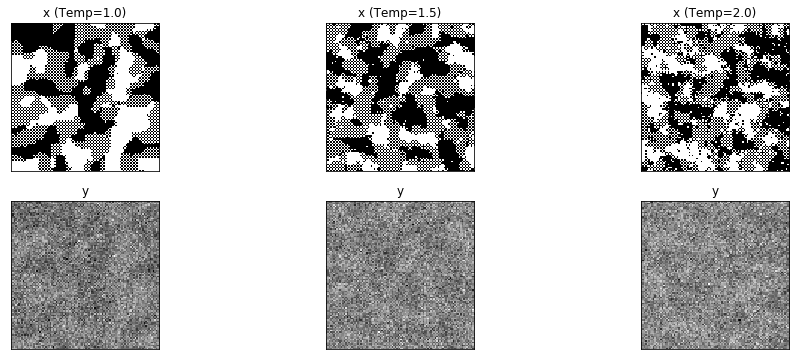

In [53]:
fig, ax = plt.subplots(2, 3, figsize=(16, 6))

for i, Temp in enumerate(Temps):
    ax[0,i].imshow(x[i], interpolation="None", vmin=-1, vmax=1, cmap="gray")
    ax[0,i].set_xticks([]), ax[0,i].set_yticks([])
    ax[0,i].set_title("x (Temp=" + str(Temp) + ")")

for i, Temp in enumerate(Temps):
    ax[1,i].imshow(y[i], interpolation="None", cmap="gray")
    ax[1,i].set_xticks([]), ax[1,i].set_yticks([])
    ax[1,i].set_title("y")
    
plt.show()

# Step 3 - Sampling the Posterior

In [17]:
from copy import copy
from gibbs_sampling_funcs import calc_neighbors_sum

# returns prob for (x_s=+1, x_s=-1)
def calc_prob_given_noise(padded_x, Temp, i, j, y, sigma):
    tmp_p_x_plus1 = np.exp((1/Temp) * calc_neighbors_sum(padded_x, i, j) * 1 - ((1/(2*(sigma**2))) * (y[i-1, j-1] - 1)**2))
    tmp_p_x_minus1 = np.exp((1/Temp) * calc_neighbors_sum(padded_x, i, j) * (-1) - ((1/(2*(sigma**2))) * (y[i-1, j-1] + 1)**2))
    p_x_plus1 = tmp_p_x_plus1 / (tmp_p_x_plus1 + tmp_p_x_minus1)
    p_x_minus1 = tmp_p_x_minus1 / (tmp_p_x_plus1 + tmp_p_x_minus1)
    return p_x_plus1, p_x_minus1


def sample_site_given_noise(padded_x, Temp, i, j, y, sigma):
    p_x = calc_prob_given_noise(padded_x, Temp, i, j, y, sigma)
    return np.random.choice([1, -1], 1, p=[p_x[0], p_x[1]])


def MRF_iteration_given_noise(padded_x, Temp, lat_size, y, sigma):
    prev_padded_x = copy(padded_x)
    for i in range(lat_size):
        for j in range(lat_size):
            padded_x[i+1][j+1] = sample_site_given_noise(prev_padded_x, Temp, i+1, j+1, y, sigma)  # Assuming padded
    return padded_x


def gibbs_sampler_given_noise(Temp, iterations, lat_size, y, sigma):
    # s = time.time()
    initial_x = np.random.randint(low=0, high=2, size=(lat_size, lat_size))*2 - 1
    padded_x = np.pad(initial_x, ((1, 1), (1, 1)), 'constant')
    for iteration in range(iterations):
        padded_x = MRF_iteration_given_noise(padded_x, Temp, lat_size, y, sigma)
    return padded_x[1:-1, 1:-1]

In [13]:
post_x = []
for i, Temp in enumerate(Temps):
    print("Temp = " + str(Temp))
    print("Sampling:")
    s = time.time()
    post_x.append(gibbs_sampler_given_noise(Temp, sweeps, lat_size, y[i], sigma))
    e = time.time()
    print("Done (" + str(round(e - s, 2)) + " secs).")
    print("---------------")

Temp = 1.0
Sampling:
Done (25.64 secs).
---------------
Temp = 1.5
Sampling:
Done (25.51 secs).
---------------
Temp = 2.0
Sampling:
Done (25.43 secs).
---------------


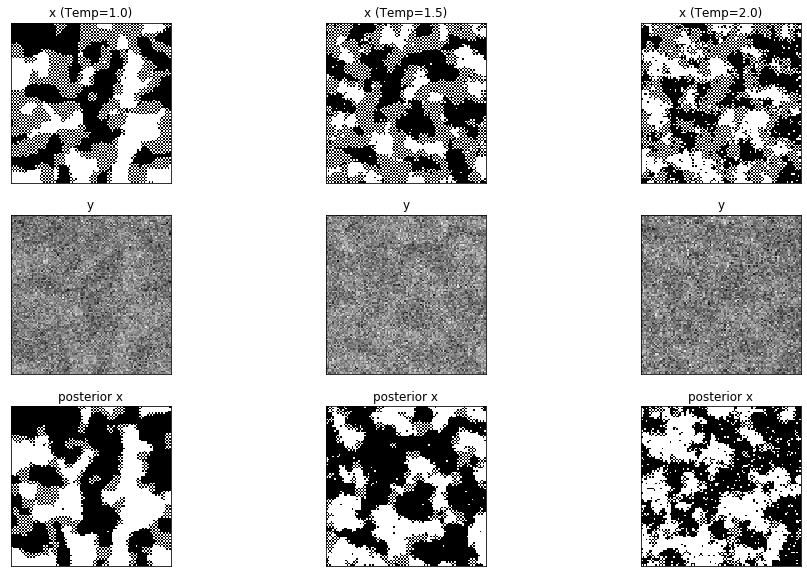

In [33]:
fig, ax = plt.subplots(3, 3, figsize=(16, 10))

for i, Temp in enumerate(Temps):
    ax[0,i].imshow(x[i], interpolation="None", vmin=-1, vmax=1, cmap="gray")
    ax[0,i].set_xticks([]), ax[0,i].set_yticks([])
    ax[0,i].set_title("x (Temp=" + str(Temp) + ")")

for i, Temp in enumerate(Temps):
    ax[1,i].imshow(y[i], interpolation="None", cmap="gray")
    ax[1,i].set_xticks([]), ax[1,i].set_yticks([])
    ax[1,i].set_title("y")
    
for i, Temp in enumerate(Temps):
    ax[2,i].imshow(post_x[i], interpolation="None", vmin=-1, vmax=1, cmap="gray")
    ax[2,i].set_xticks([]), ax[2,i].set_yticks([])
    ax[2,i].set_title("posterior x")

plt.show()

# Step 4 - ICM

In [15]:
def sample_site_given_noise_ICM(padded_x, Temp, i, j, y, sigma):
    p_x = calc_prob_given_noise(padded_x, Temp, i, j, y, sigma)
    if p_x[0] >= p_x[1]:
        return 1
    else:
        return -1
    
def MRF_iteration_given_noise_ICM(padded_x, Temp, lat_size, y, sigma):
    prev_padded_x = copy(padded_x)
    for i in range(lat_size):
        for j in range(lat_size):
            padded_x[i+1][j+1] = sample_site_given_noise_ICM(prev_padded_x, Temp, i+1, j+1, y, sigma)  # Assuming padded
    return padded_x


def gibbs_sampler_given_noise_ICM(Temp, iterations, lat_size, y, sigma):
    # s = time.time()
    initial_x = np.random.randint(low=0, high=2, size=(lat_size, lat_size))*2 - 1
    padded_x = np.pad(initial_x, ((1, 1), (1, 1)), 'constant')
    for iteration in range(iterations):
        padded_x = MRF_iteration_given_noise_ICM(padded_x, Temp, lat_size, y, sigma)
    return padded_x[1:-1, 1:-1]

In [18]:
post_x_ICM = []
for i, Temp in enumerate(Temps):
    print("Temp = " + str(Temp))
    print("Sampling:")
    s = time.time()
    post_x_ICM.append(gibbs_sampler_given_noise_ICM(Temp, sweeps, lat_size, y[i], sigma))
    e = time.time()
    print("Done (" + str(round(e - s, 2)) + " secs).")
    print("---------------")

Temp = 1.0
Sampling:
Done (10.88 secs).
---------------
Temp = 1.5
Sampling:
Done (12.68 secs).
---------------
Temp = 2.0
Sampling:
Done (12.28 secs).
---------------


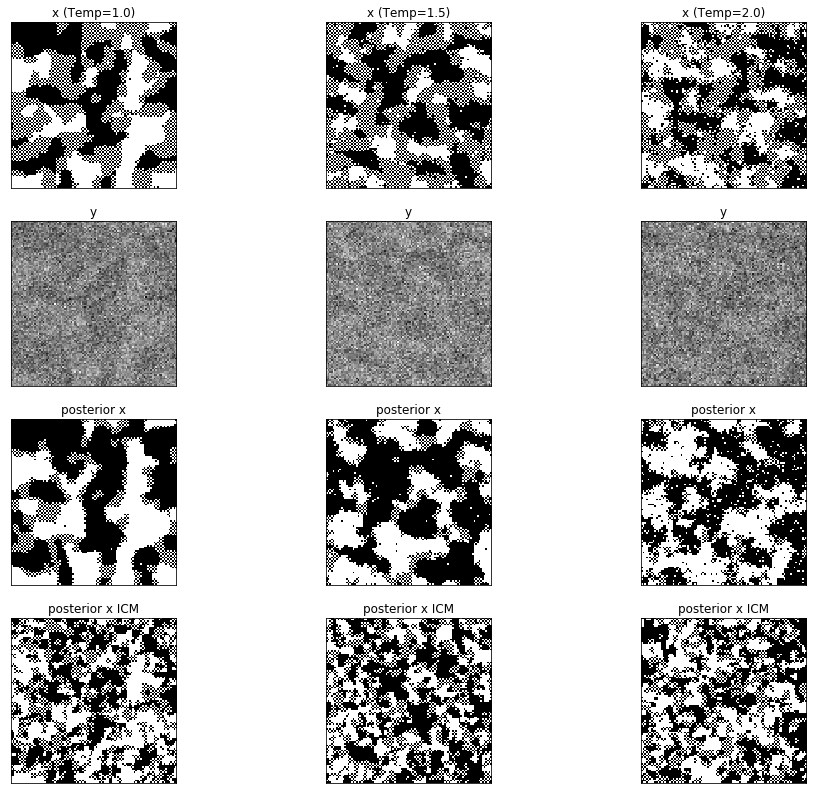

In [34]:
fig, ax = plt.subplots(4, 3, figsize=(16, 14))

for i, Temp in enumerate(Temps):
    ax[0,i].imshow(x[i], interpolation="None", vmin=-1, vmax=1, cmap="gray")
    ax[0,i].set_xticks([]), ax[0,i].set_yticks([])
    ax[0,i].set_title("x (Temp=" + str(Temp) + ")")

for i, Temp in enumerate(Temps):
    ax[1,i].imshow(y[i], interpolation="None", cmap="gray")
    ax[1,i].set_xticks([]), ax[1,i].set_yticks([])
    ax[1,i].set_title("y")
    
for i, Temp in enumerate(Temps):
    ax[2,i].imshow(post_x[i], interpolation="None", vmin=-1, vmax=1, cmap="gray")
    ax[2,i].set_xticks([]), ax[2,i].set_yticks([])
    ax[2,i].set_title("posterior x")
    
for i, Temp in enumerate(Temps):
    ax[3,i].imshow(post_x_ICM[i], interpolation="None", vmin=-1, vmax=1, cmap="gray")
    ax[3,i].set_xticks([]), ax[3,i].set_yticks([])
    ax[3,i].set_title("posterior x ICM")

plt.show()

# Step 5 - MLE

In [42]:
MLE_x = []
for i, Temp in enumerate(Temps):
    print("Temp = " + str(Temp))
    MLE = np.zeros((lat_size,lat_size), dtype=int)
    for row in range(lat_size):
        for col in range(lat_size):
            MLE[row,col] = int(np.sign(y[i][row,col]))
    MLE_x.append(MLE)
    print("---------------")

Temp = 1.0
---------------
Temp = 1.5
---------------
Temp = 2.0
---------------


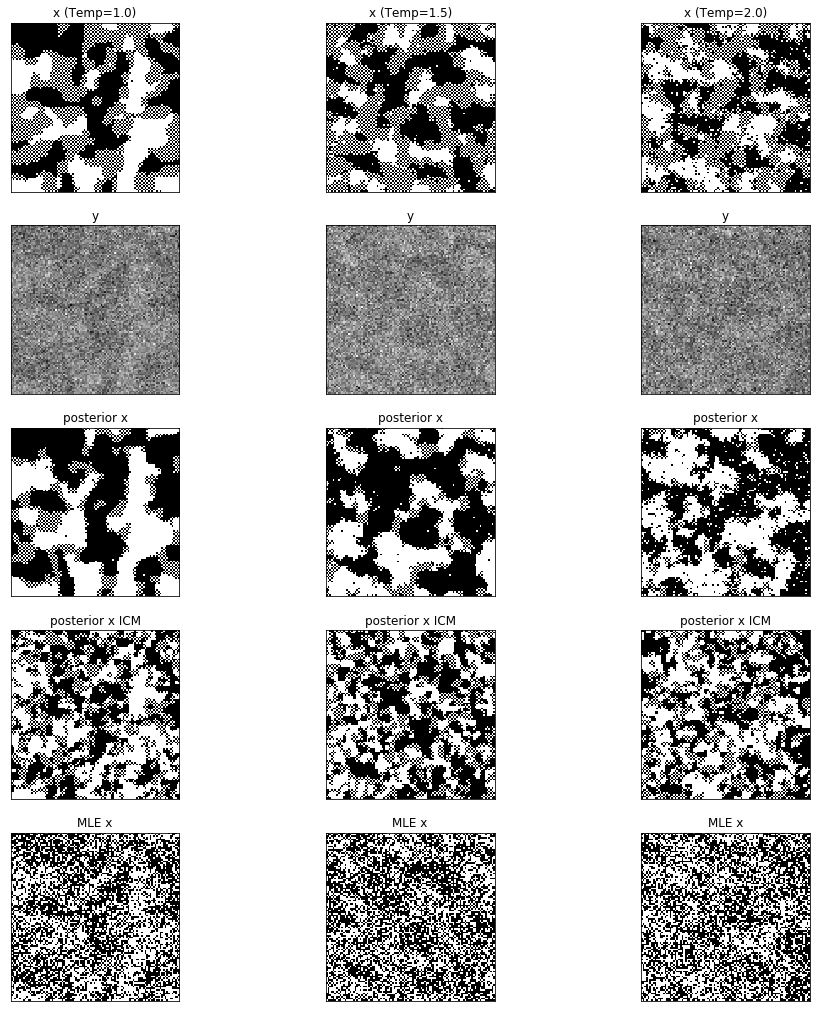

In [44]:
fig, ax = plt.subplots(5, 3, figsize=(16, 18))

for i, Temp in enumerate(Temps):
    ax[0,i].imshow(x[i], interpolation="None", vmin=-1, vmax=1, cmap="gray")
    ax[0,i].set_xticks([]), ax[0,i].set_yticks([])
    ax[0,i].set_title("x (Temp=" + str(Temp) + ")")

for i, Temp in enumerate(Temps):
    ax[1,i].imshow(y[i], interpolation="None", cmap="gray")
    ax[1,i].set_xticks([]), ax[1,i].set_yticks([])
    ax[1,i].set_title("y")
    
for i, Temp in enumerate(Temps):
    ax[2,i].imshow(post_x[i], interpolation="None", vmin=-1, vmax=1, cmap="gray")
    ax[2,i].set_xticks([]), ax[2,i].set_yticks([])
    ax[2,i].set_title("posterior x")
    
for i, Temp in enumerate(Temps):
    ax[3,i].imshow(post_x_ICM[i], interpolation="None", vmin=-1, vmax=1, cmap="gray")
    ax[3,i].set_xticks([]), ax[3,i].set_yticks([])
    ax[3,i].set_title("posterior x ICM")
    
for i, Temp in enumerate(Temps):
    ax[4,i].imshow(MLE_x[i], interpolation="None", vmin=-1, vmax=1, cmap="gray")
    ax[4,i].set_xticks([]), ax[4,i].set_yticks([])
    ax[4,i].set_title("MLE x")

plt.show()

# Results

## Temp = 1

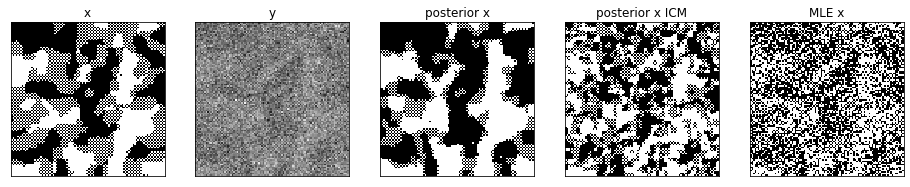

In [47]:
fig, ax = plt.subplots(1, 5, figsize=(16, 18))

i = 0

ax[0].imshow(x[i], interpolation="None", vmin=-1, vmax=1, cmap="gray")
ax[0].set_xticks([]), ax[0].set_yticks([])
ax[0].set_title("x")

ax[1].imshow(y[i], interpolation="None", cmap="gray")
ax[1].set_xticks([]), ax[1].set_yticks([])
ax[1].set_title("y")

ax[2].imshow(post_x[i], interpolation="None", vmin=-1, vmax=1, cmap="gray")
ax[2].set_xticks([]), ax[2].set_yticks([])
ax[2].set_title("posterior x")

ax[3].imshow(post_x_ICM[i], interpolation="None", vmin=-1, vmax=1, cmap="gray")
ax[3].set_xticks([]), ax[3].set_yticks([])
ax[3].set_title("posterior x ICM")

ax[4].imshow(MLE_x[i], interpolation="None", vmin=-1, vmax=1, cmap="gray")
ax[4].set_xticks([]), ax[4].set_yticks([])
ax[4].set_title("MLE x")

plt.show()

## Temp = 1.5

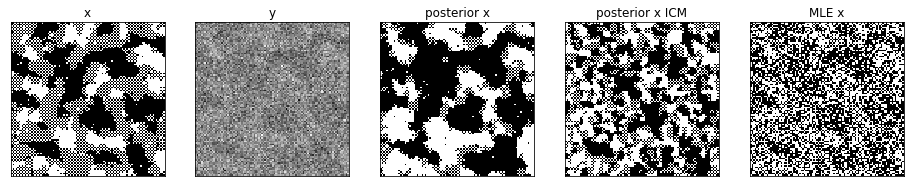

In [48]:
fig, ax = plt.subplots(1, 5, figsize=(16, 18))

i = 1

ax[0].imshow(x[i], interpolation="None", vmin=-1, vmax=1, cmap="gray")
ax[0].set_xticks([]), ax[0].set_yticks([])
ax[0].set_title("x")

ax[1].imshow(y[i], interpolation="None", cmap="gray")
ax[1].set_xticks([]), ax[1].set_yticks([])
ax[1].set_title("y")

ax[2].imshow(post_x[i], interpolation="None", vmin=-1, vmax=1, cmap="gray")
ax[2].set_xticks([]), ax[2].set_yticks([])
ax[2].set_title("posterior x")

ax[3].imshow(post_x_ICM[i], interpolation="None", vmin=-1, vmax=1, cmap="gray")
ax[3].set_xticks([]), ax[3].set_yticks([])
ax[3].set_title("posterior x ICM")

ax[4].imshow(MLE_x[i], interpolation="None", vmin=-1, vmax=1, cmap="gray")
ax[4].set_xticks([]), ax[4].set_yticks([])
ax[4].set_title("MLE x")

plt.show()

## Temp = 2

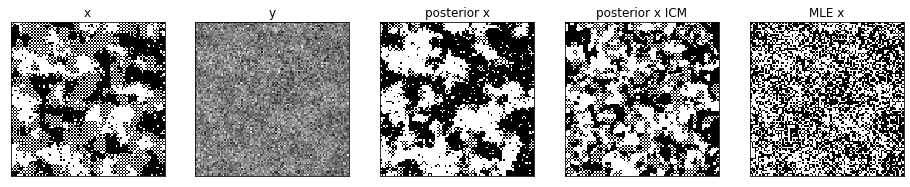

In [49]:
fig, ax = plt.subplots(1, 5, figsize=(16, 18))

i = 2

ax[0].imshow(x[i], interpolation="None", vmin=-1, vmax=1, cmap="gray")
ax[0].set_xticks([]), ax[0].set_yticks([])
ax[0].set_title("x")

ax[1].imshow(y[i], interpolation="None", cmap="gray")
ax[1].set_xticks([]), ax[1].set_yticks([])
ax[1].set_title("y")

ax[2].imshow(post_x[i], interpolation="None", vmin=-1, vmax=1, cmap="gray")
ax[2].set_xticks([]), ax[2].set_yticks([])
ax[2].set_title("posterior x")

ax[3].imshow(post_x_ICM[i], interpolation="None", vmin=-1, vmax=1, cmap="gray")
ax[3].set_xticks([]), ax[3].set_yticks([])
ax[3].set_title("posterior x ICM")

ax[4].imshow(MLE_x[i], interpolation="None", vmin=-1, vmax=1, cmap="gray")
ax[4].set_xticks([]), ax[4].set_yticks([])
ax[4].set_title("MLE x")

plt.show()